## HLCA IPF analysis - DE analysis

In [1]:
import numpy as np
import pandas as pd
import scanpy as sc

import oor_benchmark

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import milopy

In [3]:
## r2py setup
import rpy2.rinterface_lib.callbacks
import logging
rpy2.rinterface_lib.callbacks.logger.setLevel(logging.ERROR)


In [4]:
%load_ext rpy2.ipython

In [5]:
%%R
library(tidyverse)
library(patchwork)

remove_x_axis <- function(){
  theme(axis.text.x = element_blank(), axis.ticks.x = element_blank(), axis.title.x = element_blank())  
}

remove_y_axis <- function(){
  theme(axis.text.y = element_blank(), axis.ticks.y = element_blank(), axis.title.y = element_blank())  
}

System has not been booted with systemd as init system (PID 1). Can't operate.
Failed to create bus connection: Host is down


In [6]:
from adjustText import adjust_text
def gen_mpl_labels(
    adata, groupby, exclude=(), ax=None, adjust_kwargs=None, text_kwargs=None
):
    if adjust_kwargs is None:
        adjust_kwargs = {"text_from_points": False}
    if text_kwargs is None:
        text_kwargs = {}

    medians = {}

    for g, g_idx in adata.obs.groupby(groupby).groups.items():
        if g in exclude:
            continue
        medians[g] = np.median(adata[g_idx].obsm["X_umap"], axis=0)

    if ax is None:
        texts = [
            plt.text(x=x, y=y, s=k, **text_kwargs) for k, (x, y) in medians.items()
        ]
    else:
        texts = [ax.text(x=x, y=y, s=k, **text_kwargs) for k, (x, y) in medians.items()]

    adjust_text(texts, **adjust_kwargs)

In [7]:
import matplotlib

def plot_milo_diagnostics(nhood_adata, alpha = 0.1, figsize=[12, 12]):
    with matplotlib.rc_context({"figure.figsize": figsize}):

        ## Check P-value histogram
        plt.subplot(2, 2, 1)
        plt.hist(nhood_adata.obs["PValue"], bins=20)
        plt.xlabel("Uncorrected P-value")

        ## Visualize extent of multiple-testing correction
        plt.subplot(2, 2, 2)
        plt.scatter(nhood_adata.obs["PValue"], nhood_adata.obs["SpatialFDR"], s=3)
        plt.xlabel("Uncorrected P-value")
        plt.ylabel("SpatialFDR")

        ## Visualize volcano plot
        plt.subplot(2, 2, 3)
        plt.scatter(
            nhood_adata.obs["logFC"], -np.log10(nhood_adata.obs["SpatialFDR"]), s=3
        )
        plt.axhline(
            y=-np.log10(alpha),
            color="red",
            linewidth=1,
            label=f"{int(alpha*100)} % SpatialFDR",
        )
        plt.legend()
        plt.xlabel("log-Fold Change")
        plt.ylabel("- log10(SpatialFDR)")
        plt.tight_layout()

        ## Visualize MA plot
        df = nhood_adata.obs
        emp_null = df[df["SpatialFDR"] >= alpha]["logFC"].mean()
        df["Sig"] = df["SpatialFDR"] < alpha

        plt.subplot(2, 2, 4)
        sns.scatterplot(data=df, x="logCPM", y="logFC", hue="Sig")
        plt.axhline(y=0, color="grey", linewidth=1)
        plt.axhline(y=emp_null, color="purple", linewidth=1)
        plt.legend(title=f"< {int(alpha*100)} % SpatialFDR")
        plt.xlabel("Mean log-counts")
        plt.ylabel("log-Fold Change")
        plt.show()

In [8]:
def _get_cells_in_nhoods(adata, nhood_ids):
    """Get cells in neighbourhoods of interest, store the number of neighbourhoods for each cell in adata.obs['in_nhoods']"""
    in_nhoods = np.array(adata.obsm["nhoods"][:, nhood_ids.astype("int")].sum(1))
    adata.obs["in_nhoods"] = (in_nhoods > 0).astype('int')
    adata.obs["in_nhoods"] = in_nhoods 

In [9]:
## Define color palette
pal = sns.color_palette('Paired').as_hex()
design_palette = {'ACR':pal[3], 'CR':pal[7], 'AR':pal[9], 'joint_CR':pal[6]}
design_palette_df = pd.DataFrame(design_palette.values(), index =design_palette.keys() )
design_palette_df.columns = ['color']

In [10]:
%%R -i design_palette_df 
design_palette = setNames(design_palette_df$color, rownames(design_palette_df))

/home/jovyan/my-conda-envs/oor-benchmark/lib/python3.10/site-packages/rpy2/robjects/pandas2ri.py:56: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, values in obj.iteritems():


## Load milo results with ACR design

In [11]:
data_dir = '/lustre/scratch117/cellgen/team205/ed6/HLCA/'

In [12]:
acr_adata = milopy.utils.read_milo_adata(data_dir + "Kaminski_2020_oor_design.ACR.h5ad")

In [13]:
acr_adata.var = acr_adata.var.set_index("gene_name")
# sc.pp.normalize_total(acr_adata, target_sum=10000)
# sc.pp.log1p(acr_adata)

In [144]:
acr_adata.var['gene_name'] = acr_adata.var_names.copy()

In [14]:
all_cts = acr_adata.obs['Celltype_HLCA'].unique().tolist()
all_cts.sort()

ct_groups = {}
ct_groups['macrophages'] = [x for x in all_cts if 'macro' in x or 'Mφ' in x]
ct_groups['fibroblasts'] = [x for x in all_cts if 'fibroblast' in x]
ct_groups['basal'] = [x for x in all_cts if 'basal' in x or "Basal" in x]
ct_groups['AT'] = [x for x in all_cts if "AT" in x]
ct_groups['EC'] = [x for x in all_cts if "EC" in x]
ct_groups['Club'] = [x for x in all_cts if "Club" in x]
ct_groups['Goblet'] = [x for x in all_cts if "Goblet" in x]
ct_groups['SMG'] = [x for x in all_cts if "SMG" in x]
ct_groups['Multiciliated'] = [x for x in all_cts if "Multiciliated" in x]

ct_groups['Lymphoid'] = ['B cells',
 'CD4 T cells',
 'CD8 T cells',
  'NK cells',
'Plasma cells',
 'T cells proliferating']
    
ct_groups['Myeloid'] = [
 'Mast cells',
'Classical monocytes',
 'DC1',
 'DC2',
 'Migratory DCs',
 'Non-classical monocytes',
 'Plasmacytoid DCs'    
]
 
min_cells = 10

ct_groups_rev = {x:k for k,v in ct_groups.items() for x in v}
for ct in all_cts:
    if sum(acr_adata.obs['Celltype_HLCA'] == ct) < min_cells:
        ct_groups_rev[ct] = np.nan
    else:        
        if ct not in ct_groups_rev.keys():
            ct_groups_rev[ct] = ct


In [15]:
## Annotate nhoods by cell type
milopy.utils.annotate_nhoods(acr_adata, anno_col='Celltype_HLCA')
acr_adata.uns['nhood_adata'].obs['nhood_annotation_group'] = [ct_groups_rev[x] for x in acr_adata.uns['nhood_adata'].obs['nhood_annotation']]

In [16]:
# nhood_adata = acr_adata.uns['nhood_adata'].copy()

# nhood_adata[nhood_adata.obs['nhood_annotation_group'].isin(['AT', 'basal'])].obs.sort_values("logFC")

# milopy.plot.plot_nhood(acr_adata, pd.Series([2060]))

# _get_cells_in_nhoods(acr_adata, pd.Series([796]))
# nh796 = acr_adata.obs_names[acr_adata.obs.in_nhoods ==1]

# _get_cells_in_nhoods(acr_adata, pd.Series([219]))
# nh219 = acr_adata.obs_names[acr_adata.obs.in_nhoods ==1]

In [20]:
# def get_nhood_expression_sample(acr_adata):
genes = ['DSP', 'KRT17', 'KRT5']

nhood_adata = acr_adata.uns['nhood_adata'].copy()
sample_col = nhood_adata.uns['sample_col']
all_samples = nhood_adata.var_names

In [30]:
# for s in all_samples:
s = all_samples[0]
s_cells = {s:acr_adata.obs_names[acr_adata.obs[sample_col] == s] for s in all_samples}

X_cells = acr_adata[:,genes][s_cells[s]].X
nhood_mat = acr_adata[s_cells[s]].obsm['nhoods']

In [32]:
## Aggregate over nhoods, taking the sum
nhoods_X = X_cells.T.dot(nhood_mat)

In [36]:
nhoods_X

<3x2729 sparse matrix of type '<class 'numpy.float32'>'
	with 190 stored elements in Compressed Sparse Column format>

In [72]:
import diff2atlas
import os

def run_glmGamPoi_DE(pbulk_adata, 
                     design = '~ Site + nhood_groups',
                    ref_level = 'in_nhoods_other',
                    contrast = 'nhood_groupsin_nhoods_critical',
                     n_hvgs = 5000):
    '''
    Run R code for DE analysis with glmGamPoi
    
    Params:
    ------
    - pbulk_adata: anndata object with pseudobulked data
    
    '''
    
    ## Define R function
    glmgampoi_str = f'''
        library(SingleCellExperiment)
        library(glmGamPoi)
        library(scran)
        library(scater)

        run_de <- function(args){{
            pbulk_sdata_X <- args[[1]]
            pbulk_sdata_obs <- args[[2]]
            pbulk_sdata_var <- args[[3]]
            n_hvgs <- args[[4]]

            sce <- SingleCellExperiment(assays = list(counts = t(pbulk_sdata_X)), colData = pbulk_sdata_obs)
            sce <- logNormCounts(sce)

            ## Feature selection w scran (just on test cell types)
            dec <- modelGeneVar(sce)
            hvgs <- getTopHVGs(dec, n = n_hvgs)
            subset_sce <- sce[hvgs,]

            ## Fit
            fit <- glm_gp(subset_sce, design = {design}, reference_level = '{ref_level}')

            ## Test 
            de_res <- test_de(fit, contrast = '{contrast}')    
            de_res[,'gene_name'] <- pbulk_sdata_var[hvgs,]['gene_name']
            return(de_res)
        }}'''
    
    import rpy2.robjects.pandas2ri
    import rpy2.robjects.numpy2ri
    from rpy2.robjects.packages import STAP
    
    ## Get anndata components
    pbulk_sdata_X = pbulk_adata.X.toarray().copy()
    pbulk_sdata_obs = pbulk_adata.obs.copy()
    pbulk_sdata_var = pbulk_adata.var.copy()
    
    r_pkg = STAP(glmgampoi_str, "r_pkg")
    # this was needed for the code to run on jhub
    # if you have a different version of rpy2 you may not need these two lines
    rpy2.robjects.pandas2ri.activate()
    rpy2.robjects.numpy2ri.activate()
    
    # PASS OBJECTS INTO FUNCTION
    args = [pbulk_sdata_X, pbulk_sdata_obs, pbulk_sdata_var, n_hvgs]
    de_res_df = r_pkg.run_de(args).to_csvfile('./DE_results.csv')
    de_res_df = pd.read_csv('./DE_results.csv', index_col=0)
    de_res_df.index = de_res_df['gene_name']
    de_res_df.drop('name', 1, inplace=True)
    os.remove('./DE_results.csv')
    return(de_res_df)

def find_nhood_group_markers(
    adata, 
    test_group: str,
    ctrl_group: str,
    confounders_obs = None,
    nhood_group_obs: str = 'nhood_groups',
    min_n_nhoods: int = 3,
    pbulk_use_layer: str = None,
    n_hvgs: int = 5
    ):
    '''
    Find genes differentially expressed between cells in 2 groups of neighbourhoods
    
    Params:
    -------
    - adata: AnnData object storing nhood info in adata.uns['nhood_adata']
    - design: design formula for the test, passed to glmGamPoi
    - test_group: which neighbourhood group is the test group?
    - ctrl_group: which neighbourhood group is the reference group?
    - nhood_group_obs: the column in adata.uns['nhood_adata'] storing the neighbourhood group information
    - min_n_nhoods: cells are assigned to a neighbourhood group only if it belongs to at least min_n_nhoods neighbourhoods in the group
    - pbulk_use_layer: layer storing counts (if None, adata.X is used) 
    - n_hvgs: how many HVGS to use for the DE test (the more you use, the longer it takes)
    
    Returns:
    --------
    pd.DataFrame storing DE test results
    '''

#     ## Find cells in nhoods of interest
#     groups = adata.uns['nhood_adata'].obs[nhood_group_obs].dropna().unique()
#     for g in groups:
#         nhoods_oi = adata.uns['nhood_adata'].obs_names[adata.uns['nhood_adata'].obs[nhood_group_obs] == g]
#         diff2atlas.utils.get_cells_in_nhoods(adata, nhoods_oi)
#         adata.obs[f'in_nhoods_{g}'] = adata.obs['in_nhoods'].copy()

#     ## Find most representative group (cell belongs to mostly to neighbourhoods of that group)
#     adata.obs['nhood_groups'] = np.nan
#     adata.obs['nhood_groups'] = adata.obs[[f'in_nhoods_{g}' for g in groups]].idxmax(1)
#     ## Keep only if cell is in at least min_n_nhoods nhoods of the same group
#     adata.obs.loc[~(adata.obs[[f'in_nhoods_{g}' for g in groups]] > min_n_nhoods).any(1), 'nhood_groups'] = np.nan 

    ## Make pseudobulk adata for cells if different nhood groups and samples
    sdata = adata[~adata.obs['nhood_groups'].isna()].copy()
    if confounders_obs is None:
        design = '~ nhood_groups'
        pbulk_sdata = diff2atlas.utils.anndata2pseudobulk(
            sdata, 
            group_by=[adata.uns['nhood_adata'].uns['sample_col'], 'nhood_groups'], 
            min_ncells=1, 
            use_layer=pbulk_use_layer)
    else:
        if isinstance(confounders_obs, str):
            confounder_obs = [confounders_obs]
        design = "~ " + ' + '.join(confounders_obs) + ' + nhood_groups'
        pbulk_sdata = diff2atlas.utils.anndata2pseudobulk(
            sdata, 
            group_by=[nhood_adata.uns['sample_col'], 'nhood_groups'] + confounders_obs, 
            min_ncells=1, 
            use_layer=pbulk_use_layer)
    
    pbulk_sdata.var = adata.var.copy() 
    de_results = run_glmGamPoi_DE(pbulk_sdata, design=design, 
                           ref_level = f'{ctrl_group}', 
                           contrast = f'nhood_groups{test_group}', 
                           n_hvgs=n_hvgs)
    return(de_results)

In [20]:
# ## Select nhoods of interest
# cd14_mono_res = mono_res[mono_res.nhood_annotation == 'CD14_mono']
# low_ifn_monos_nhoods = cd14_mono_res.index[(cd14_mono_res.SpatialFDR < 0.1) & (cd14_mono_res.logFC > 0) & (cd14_mono_res.nhood_IFN_signature < 0.2)]
# high_ifn_monos_nhoods = cd14_mono_res.index[(cd14_mono_res.SpatialFDR < 0.1) & (cd14_mono_res.logFC > 0) & (cd14_mono_res.nhood_IFN_signature > 0.2)]

# other_monos_nhoods = cd14_mono_res.index[~((cd14_mono_res.SpatialFDR < 0.1) & (cd14_mono_res.logFC > 0))]

# ## Mark nhood groups
# nhood_adata = adata.uns['nhood_adata'].copy()
# nhood_adata.obs['nhood_groups'] = np.nan
# nhood_adata.obs.loc[low_ifn_monos_nhoods, 'nhood_groups'] = 'low_ifn_enr'
# nhood_adata.obs.loc[high_ifn_monos_nhoods, 'nhood_groups'] = 'high_ifn_enr'
# nhood_adata.obs.loc[other_monos_nhoods, 'nhood_groups'] = 'other_CD14_monos'
# adata.uns['nhood_adata'] = nhood_adata.copy()

In [379]:
# enr_basal = nhood_adata.obs[(nhood_adata.obs['nhood_annotation_group'] == "basal") & 
#                             (nhood_adata.obs['logFC'] > 3) & 
#                             (nhood_adata.obs['SpatialFDR'] < 0.01)].index
enr_basal = '219'
basaloid = '796'
# depl_basal = nhood_adata.obs[(nhood_adata.obs['nhood_annotation_group'] == "basal") & (nhood_adata.obs['logFC'] < 3)].index

In [387]:
acr_adata.obs['nhood_groups'] = 'other'
nhood_groups = {"KRT17hi_basal":enr_basal, "Basaloid":basaloid}
for k,gr in nhood_groups.items():
    _get_cells_in_nhoods(acr_adata, pd.Series(gr))
    acr_adata.obs.loc[acr_adata.obs['in_nhoods'] == 1, 'nhood_groups'] = k

acr_adata.obs.loc[(acr_adata.obs['Celltype_HLCA'].isin(ct_groups['basal'])) & (acr_adata.obs['nhood_groups'] == 'other'), 'nhood_groups'] = 'Normal_basal'

In [388]:
acr_adata.obs['nhood_groups'] = acr_adata.obs['nhood_groups'].astype("category").cat.reorder_categories(['other', 'Normal_basal', 'Basaloid', 'KRT17hi_basal'])

In [389]:
acr_adata[acr_adata.obs['Celltype_HLCA'].isin(ct_groups['basal'] + ct_groups['AT'])].obs[['nhood_groups', 'Celltype_HLCA']].value_counts()

nhood_groups   Celltype_HLCA        
other          AT2                      4426
               AT1                      1298
               Transitional Club-AT2    1046
Normal_basal   Basal resting             882
               Suprabasal                680
KRT17hi_basal  Suprabasal                287
Basaloid       AT2                       234
KRT17hi_basal  Basal resting              62
Basaloid       Suprabasal                 44
               AT1                        21
               Basal resting               1
dtype: int64

In [391]:
acr_adata[acr_adata.obs['Celltype_HLCA'].isin(ct_groups['basal'] + ct_groups['AT'])].obs[['nhood_groups', 'disease']].value_counts()

nhood_groups   disease
other          Control    3254
               IPF        1947
               COPD       1569
Normal_basal   IPF        1228
KRT17hi_basal  IPF         338
Basaloid       IPF         280
Normal_basal   COPD        171
               Control     163
Basaloid       COPD         18
KRT17hi_basal  Control       7
               COPD          4
Basaloid       Control       2
dtype: int64

In [321]:
## Exclude genes for testing
sc.pp.calculate_qc_metrics(acr_adata, inplace=True)
tot_counts = acr_adata[acr_adata.obs['Celltype_HLCA'].isin(ct_groups['basal'] + ct_groups['AT'])].X.sum(0)
test_var_names = acr_adata.var_names[
    (acr_adata.var['n_cells_by_counts']/acr_adata.n_obs < 0.5) & # exclude ubiquitously expressed
    (np.array(tot_counts).ravel() >= 5) # exclude lowly expressed
]

In [ ]:
acr_adata.layers['counts'] = acr_adata.X.copy()

sc.pp.normalize_total(acr_adata, target_sum=10000)
sc.pp.log1p(acr_adata)

In [392]:
## Run DE testing
DE_KRT17hi_vs_normal = find_nhood_group_markers(
    acr_adata[acr_adata.obs['Celltype_HLCA'].isin(ct_groups['basal'] + ct_groups['AT'])][:,test_var_names], 
    test_group='KRT17hi_basal', 
    ctrl_group='Normal_basal', 
    n_hvgs = 7500,
    pbulk_use_layer='counts'
    )


/home/jovyan/my-conda-envs/oor-benchmark/lib/python3.10/site-packages/rpy2/robjects/pandas2ri.py:56: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, values in obj.iteritems():
/tmp/ipykernel_1924/1493349435.py:68: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  de_res_df.drop('name', 1, inplace=True)


In [393]:
DE_Basaloid_vs_normal = find_nhood_group_markers(
    acr_adata[acr_adata.obs['Celltype_HLCA'].isin(ct_groups['basal'] + ct_groups['AT'])][:,test_var_names], 
    test_group='Basaloid', 
    ctrl_group='Normal_basal', 
    n_hvgs = 7500,
    pbulk_use_layer='counts'
    )


/home/jovyan/my-conda-envs/oor-benchmark/lib/python3.10/site-packages/rpy2/robjects/pandas2ri.py:56: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, values in obj.iteritems():
/tmp/ipykernel_1924/1493349435.py:68: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  de_res_df.drop('name', 1, inplace=True)


/home/jovyan/my-conda-envs/oor-benchmark/lib/python3.10/site-packages/rpy2/robjects/pandas2ri.py:56: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, values in obj.iteritems():


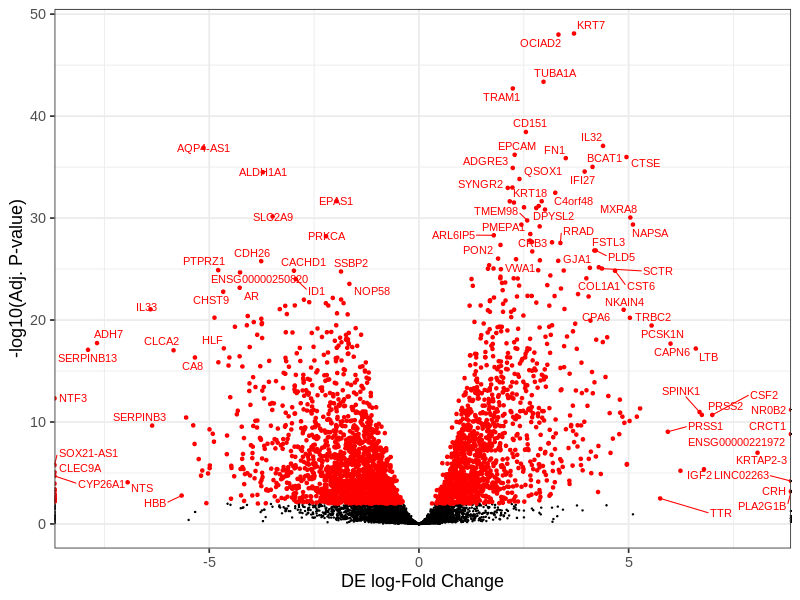

In [394]:
%%R -i DE_Basaloid_vs_normal -w 800 -h 600 -o DE_Basaloid_vs_normal
max_lfc = 15
DE_Basaloid_vs_normal$lfc <- ifelse(abs(DE_Basaloid_vs_normal$lfc) > max_lfc, sign(DE_Basaloid_vs_normal$lfc) * Inf, DE_Basaloid_vs_normal$lfc)
DE_Basaloid_vs_normal %>%
#     filter(contrast == 'mild_enr-other') %>%
    mutate(signif = adj_pval < 0.01) %>%
    mutate(label = ifelse(signif & (abs(lfc) > 0.75), as.character(gene_name), NA)) %>%
    ggplot(aes(lfc, -log10(adj_pval))) + 
    geom_point(size=0.5) +
    geom_point(data=. %>% filter(signif), color='red') +
    ggrepel::geom_text_repel(aes(label=label), color='red') +
    theme_bw(base_size=18) +
    xlab("DE log-Fold Change") +
    ylab('-log10(Adj. P-value)') 
#     ggsave(paste0(figdir, 'volcano_CD14_monos.png'), height=7, width=7) +
#     ggsave(paste0(figdir, 'volcano_CD14_monos.pdf'), height=7, width=7) 

/home/jovyan/my-conda-envs/oor-benchmark/lib/python3.10/site-packages/rpy2/robjects/pandas2ri.py:56: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, values in obj.iteritems():


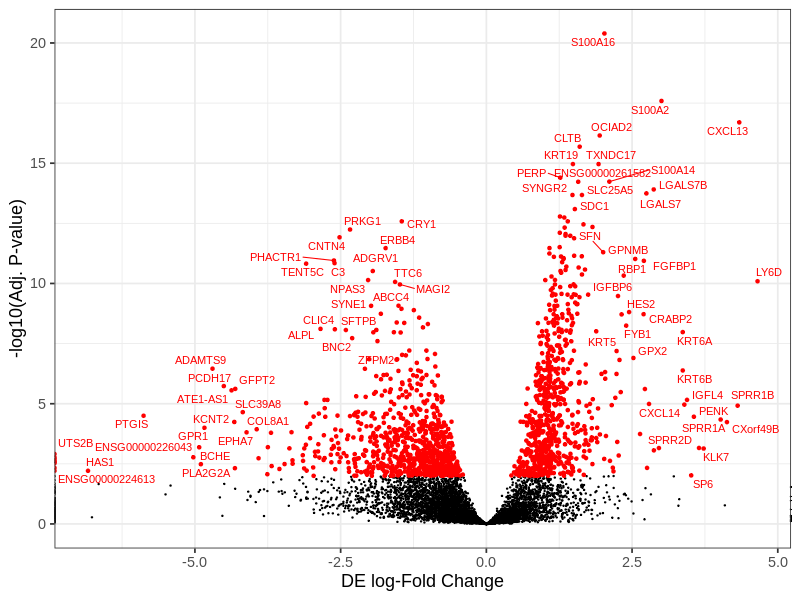

In [395]:
%%R -i DE_KRT17hi_vs_normal -w 800 -h 600 -o DE_KRT17hi_vs_normal
max_lfc = 15
DE_KRT17hi_vs_normal$lfc <- ifelse(abs(DE_KRT17hi_vs_normal$lfc) > max_lfc, sign(DE_KRT17hi_vs_normal$lfc) * Inf, DE_KRT17hi_vs_normal$lfc)
DE_KRT17hi_vs_normal %>%
#     filter(contrast == 'mild_enr-other') %>%
    mutate(signif = adj_pval < 0.01) %>%
    mutate(label = ifelse(signif & (abs(lfc) > 0.75), as.character(gene_name), NA)) %>%
    ggplot(aes(lfc, -log10(adj_pval))) + 
    geom_point(size=0.5) +
    geom_point(data=. %>% filter(signif), color='red') +
    ggrepel::geom_text_repel(aes(label=label), color='red') +
    theme_bw(base_size=18) +
    xlab("DE log-Fold Change") +
    ylab('-log10(Adj. P-value)') 
#     ggsave(paste0(figdir, 'volcano_CD14_monos.png'), height=7, width=7) +
#     ggsave(paste0(figdir, 'volcano_CD14_monos.pdf'), height=7, width=7) 

In [396]:
DE_Basaloid_vs_normal['comparison'] = 'Basaloid_vs_normal'
DE_KRT17hi_vs_normal['comparison'] = 'KRT17hi_vs_normal'

In [397]:
lfc_df = pd.concat([DE_KRT17hi_vs_normal, DE_Basaloid_vs_normal])[['lfc', 'gene_name', 'comparison']].pivot(index='gene_name', values='lfc', columns='comparison')
fdr_df = pd.concat([DE_KRT17hi_vs_normal, DE_Basaloid_vs_normal])[['adj_pval', 'gene_name', 'comparison']].pivot(index='gene_name', values='adj_pval', columns='comparison')

In [398]:
alpha = 0.1
lfc_df['signif_group'] = 'other'
lfc_df.loc[(fdr_df['Basaloid_vs_normal'] < alpha) & (fdr_df['KRT17hi_vs_normal'] < alpha) &
           (lfc_df['Basaloid_vs_normal'] > 0) & (lfc_df['KRT17hi_vs_normal'] > 0), 
           'signif_group'] = 'enr_both'
lfc_df.loc[(fdr_df['Basaloid_vs_normal'] >= alpha) & (fdr_df['KRT17hi_vs_normal'] < alpha) &
           (lfc_df['Basaloid_vs_normal'] < 0) & (lfc_df['KRT17hi_vs_normal'] > 0), 
           'signif_group'] = 'enr_KRT17hi'
lfc_df.loc[(fdr_df['Basaloid_vs_normal'] < alpha) & (fdr_df['KRT17hi_vs_normal'] >= alpha) &
                      (lfc_df['Basaloid_vs_normal'] > 0) & (lfc_df['KRT17hi_vs_normal'] < 0), 
           'signif_group'] = 'enr_Basaloid'
lfc_df

comparison,Basaloid_vs_normal,KRT17hi_vs_normal,signif_group
gene_name,,,
A2M,-0.180051,-0.275862,other
A2MP1,0.517779,0.539290,other
A4GALT,-2.140910,0.655748,other
AACSP1,-2.673203,-2.084202,other
AADAC,-1.875612,-0.954930,other
...,...,...,...
ZSCAN31,-1.134108,-0.567028,other
ZSWIM4,-0.725843,-0.200199,other
ZSWIM5,-0.918422,-0.963548,other


/home/jovyan/my-conda-envs/oor-benchmark/lib/python3.10/site-packages/rpy2/robjects/pandas2ri.py:56: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, values in obj.iteritems():


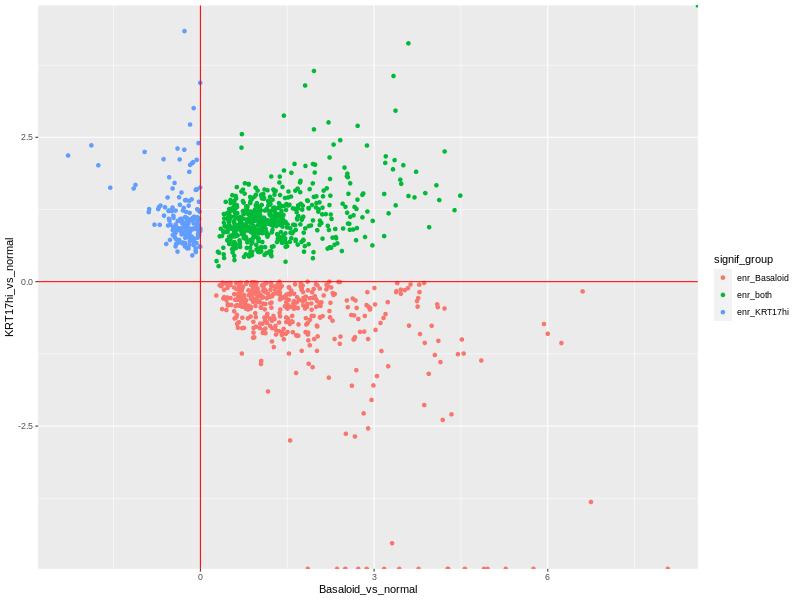

In [399]:
%%R -i lfc_df -w 800 -h 600 
max_lfc = 15
lfc_df %>%
# head()
filter(signif_group != 'other') %>%
ggplot(aes(Basaloid_vs_normal, KRT17hi_vs_normal, color=signif_group))+
geom_point() +
geom_vline(xintercept=0, color='red') + geom_hline(yintercept=0, color='red')

In [400]:
lfc_df.loc[['KRT17','KRT5', 'DSP']]

comparison,Basaloid_vs_normal,KRT17hi_vs_normal,signif_group
gene_name,,,
KRT17,0.735422,1.592818,enr_both
KRT5,-1.846722,2.235186,other
DSP,0.744187,1.172783,enr_both


In [401]:
lfc_df[(lfc_df['signif_group'] == 'enr_both') & (lfc_df['Basaloid_vs_normal'] >0)].sort_values('Basaloid_vs_normal', ascending=False)[0:50]

comparison,Basaloid_vs_normal,KRT17hi_vs_normal,signif_group
gene_name,,,
ENSG00000230939,inf,inf,enr_both
CDKN2A,4.488348,1.490151,enr_both
IL32,4.389947,1.237573,enr_both
TAGLN,4.218742,2.254402,enr_both
ENSG00000259342,4.126558,1.412968,enr_both
CDKN2B,4.076088,1.669570,enr_both
IFI27,3.950951,0.943392,enr_both
SEMA7A,3.885159,1.533475,enr_both
CAMK2N1,3.725656,1.903042,enr_both


In [402]:
lfc_df[(lfc_df['signif_group'] == 'enr_KRT17hi') & (lfc_df['KRT17hi_vs_normal'] >0)].sort_values('KRT17hi_vs_normal', ascending=False)

comparison,Basaloid_vs_normal,KRT17hi_vs_normal,signif_group
gene_name,,,
CXCL13,-0.274486,4.338994,enr_KRT17hi
IGFL4,-0.002285,3.443001,enr_KRT17hi
S100A2,-0.116072,3.004421,enr_KRT17hi
LYNX1-SLURP2,-0.177639,2.720287,enr_KRT17hi
FYB1,-0.032956,2.398899,enr_KRT17hi
...,...,...,...
EID1,-0.079465,0.576896,enr_KRT17hi
PRDX6,-0.081951,0.535657,enr_KRT17hi
RBM8B,-0.395126,0.521304,enr_KRT17hi


In [403]:
lfc_df[(lfc_df['signif_group'] == 'enr_Basaloid') & (lfc_df['Basaloid_vs_normal'] >2)].sort_values('Basaloid_vs_normal', ascending=False)[0:50]

comparison,Basaloid_vs_normal,KRT17hi_vs_normal,signif_group
gene_name,,,
KRTAP2-3,8.073991,-inf,enr_Basaloid
PRSS2,6.745643,-3.814754,enr_Basaloid
LTB,6.601468,-0.169180,enr_Basaloid
IGF2,6.235271,-1.063113,enr_Basaloid
CAPN6,5.999275,-0.902026,enr_Basaloid
PRSS1,5.934253,-0.733358,enr_Basaloid
TTR,5.751820,-inf,enr_Basaloid
C5orf46,5.273435,-inf,enr_Basaloid
BIRC7,4.959788,-inf,enr_Basaloid


In [404]:
markers = {"KRT17hi":lfc_df[(lfc_df['signif_group'] == 'enr_KRT17hi') & (lfc_df['KRT17hi_vs_normal'] > 2)].sort_values('KRT17hi_vs_normal', ascending=False)[0:20].index,
"Basaloid":lfc_df[(lfc_df['signif_group'] == 'enr_Basaloid') & (lfc_df['Basaloid_vs_normal'] > 3)].sort_values('Basaloid_vs_normal', ascending=False)[0:20].index,
"both":lfc_df[(lfc_df['signif_group'] == 'enr_both') & (lfc_df['Basaloid_vs_normal'] > 2)].sort_values('Basaloid_vs_normal', ascending=False)[0:20].index}

/home/jovyan/my-conda-envs/oor-benchmark/lib/python3.10/site-packages/scanpy/plotting/_dotplot.py:749: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


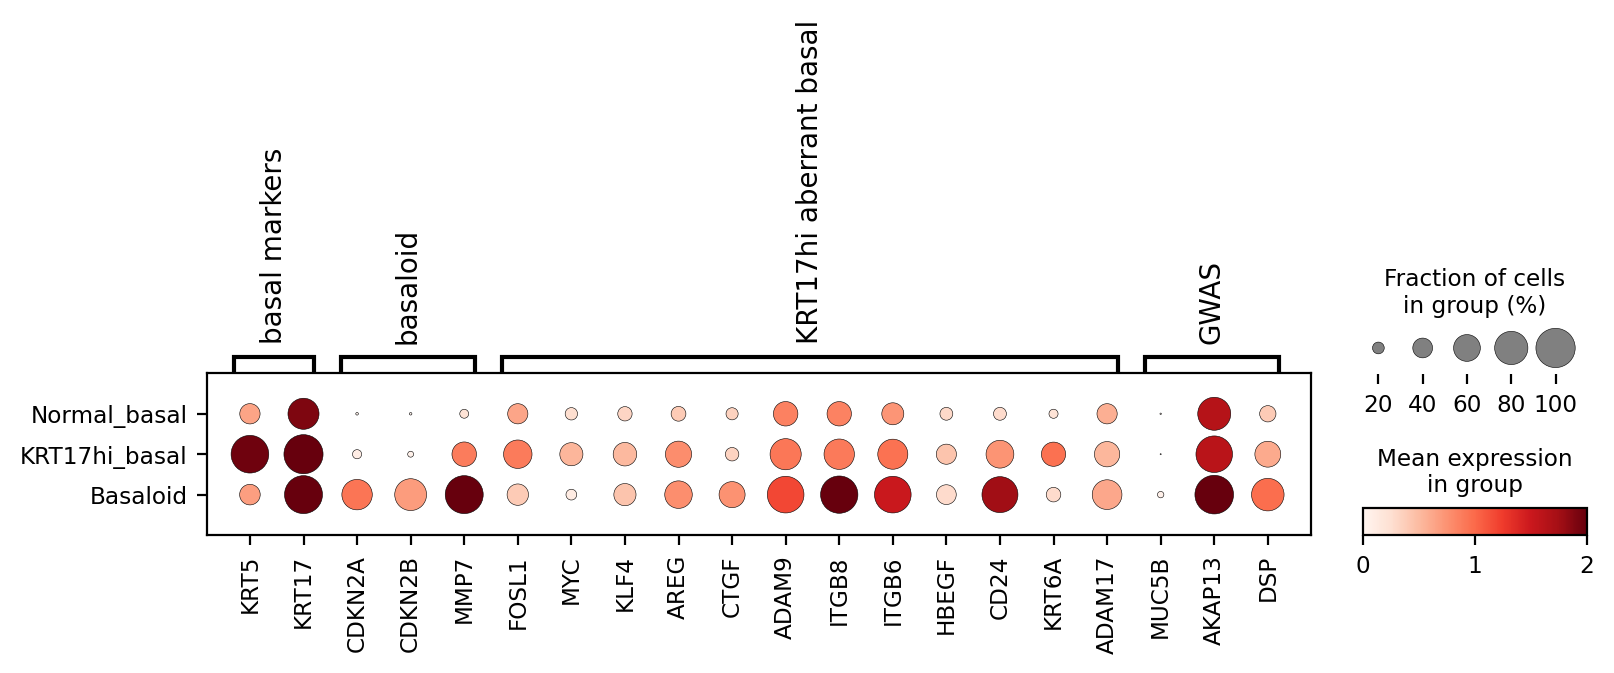

In [665]:
acr_adata.obs['nhood_groups'] = acr_adata.obs['nhood_groups'].cat.reorder_categories(['other', 'Normal_basal', 'KRT17hi_basal', 'Basaloid'])

sc.pl.dotplot(acr_adata[acr_adata.obs['Celltype_HLCA'].isin(ct_groups['basal'])], 
              {'basal markers':['KRT5', 'KRT17'], 
               'basaloid':['CDKN2A', 'CDKN2B', 'MMP7'],
               'KRT17hi aberrant basal':['FOSL1','MYC','KLF4', 'AREG', "CTGF", 'ADAM9', "ITGB8", 'ITGB6', 'HBEGF', 'CD24', 'KRT6A', 'ADAM17'],
               'GWAS':['MUC5B', "AKAP13", "DSP"]
              }, cmap='Reds',
              groupby='nhood_groups', vmin=0, vmax=2)

In [490]:
n_cells = acr_adata[acr_adata.obs['Celltype_HLCA'].isin(ct_groups['basal'])].obs.groupby(['nhood_groups', 'disease', 'individual']).size().reset_index()
n_cells['n_cells'] = n_cells[0]

/home/jovyan/my-conda-envs/oor-benchmark/lib/python3.10/site-packages/rpy2/robjects/pandas2ri.py:56: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, values in obj.iteritems():


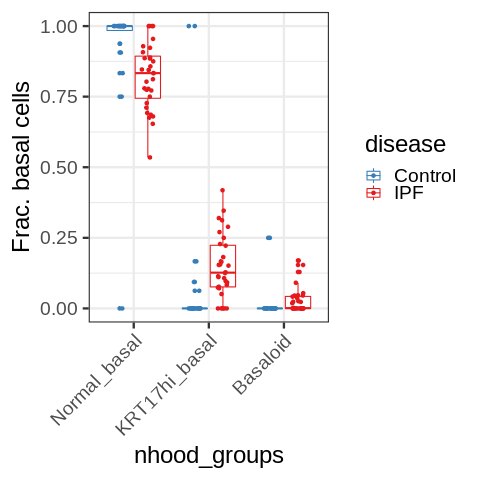

In [491]:
%%R -i n_cells
n_cells %>%
filter(disease!='COPD') %>%
group_by(individual, disease) %>%
mutate(frac_cells=n_cells/sum(n_cells)) %>%
ungroup() %>%
ggplot(aes(nhood_groups, frac_cells, color=disease)) +
geom_boxplot() +
geom_point(position=position_jitterdodge()) +
theme_bw(base_size=24) +
scale_color_brewer(palette='Set1', direction=-1) +
ylab("Cell phenotype") + ylab('Frac. basal cells') +
theme(axis.text.x=element_text(angle=45, vjust=1, hjust=1))

In [492]:
DE_Basaloid_vs_KRT17hi = find_nhood_group_markers(
    acr_adata[acr_adata.obs['Celltype_HLCA'].isin(ct_groups['basal'] + ct_groups['AT'])][:,test_var_names], 
    test_group='Basaloid', 
    ctrl_group='KRT17hi_basal', 
    n_hvgs = 7500,
    pbulk_use_layer='counts'
    )

/home/jovyan/my-conda-envs/oor-benchmark/lib/python3.10/site-packages/rpy2/robjects/pandas2ri.py:56: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, values in obj.iteritems():
/tmp/ipykernel_1924/1493349435.py:68: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  de_res_df.drop('name', 1, inplace=True)


/home/jovyan/my-conda-envs/oor-benchmark/lib/python3.10/site-packages/rpy2/robjects/pandas2ri.py:56: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, values in obj.iteritems():


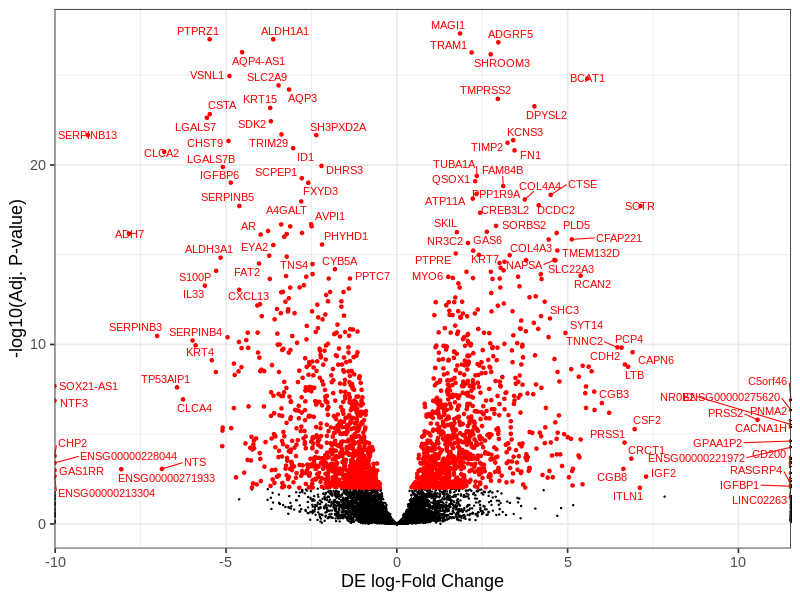

In [493]:
%%R -i DE_Basaloid_vs_KRT17hi -w 800 -h 600 -o DE_Basaloid_vs_KRT17hi
max_lfc = 15
DE_Basaloid_vs_KRT17hi$lfc <- ifelse(abs(DE_Basaloid_vs_KRT17hi$lfc) > max_lfc, sign(DE_Basaloid_vs_KRT17hi$lfc) * Inf, DE_Basaloid_vs_KRT17hi$lfc)
DE_Basaloid_vs_KRT17hi %>%
#     filter(contrast == 'mild_enr-other') %>%
    mutate(signif = adj_pval < 0.01) %>%
    mutate(label = ifelse(signif & (abs(lfc) > 0.75), as.character(gene_name), NA)) %>%
    ggplot(aes(lfc, -log10(adj_pval))) + 
    geom_point(size=0.5) +
    geom_point(data=. %>% filter(signif), color='red') +
    ggrepel::geom_text_repel(aes(label=label), color='red') +
    theme_bw(base_size=18) +
    xlab("DE log-Fold Change") +
    ylab('-log10(Adj. P-value)') 
#     ggsave(paste0(figdir, 'volcano_CD14_monos.png'), height=7, width=7) +
#     ggsave(paste0(figdir, 'volcano_CD14_monos.pdf'), height=7, width=7) 

In [351]:
DE_Basaloid_vs_KRT17hi.loc[lfc_df[lfc_df['signif_group'] == 'enr_Basaloid'].index]

,pval,adj_pval,f_statistic,df1,df2,lfc,gene_name
gene_name,,,,,,,
ABLIM3,1.127056e-05,0.000090,19.973958,1,289.978051,2.065757,ABLIM3
ACHE,2.763148e-03,0.011178,9.113311,1,289.978051,2.027981,ACHE
AGER,1.911954e-03,0.008208,9.811100,1,289.978051,3.708655,AGER
AMOT,2.429683e-06,0.000023,23.135990,1,289.978051,2.537090,AMOT
ANGPTL4,1.606384e-05,0.000122,19.250899,1,289.978051,2.681589,ANGPTL4
...,...,...,...,...,...,...,...
ZFAND2A,2.264182e-02,0.064691,5.251721,1,289.978051,1.279371,ZFAND2A
ZMAT3,2.160277e-07,0.000003,28.220269,1,289.978051,1.656269,ZMAT3
ZNF355P,1.395631e-05,0.000109,19.537521,1,289.978051,3.608452,ZNF355P


In [503]:
DE_Basaloid_vs_KRT17hi

,pval,adj_pval,f_statistic,df1,df2,lfc,gene_name
SFTPC,0.000019,0.000133,18.910248,1,291.127484,4.684723,SFTPC
SCGB1A1,0.000003,0.000023,22.912508,1,291.127484,-3.064083,SCGB1A1
SCGB3A2,0.013034,0.038336,6.240978,1,291.127484,2.110843,SCGB3A2
SFTPA2,0.313130,0.472626,1.020960,1,291.127484,0.963716,SFTPA2
SFTPA1,0.272312,0.426020,1.209639,1,291.127484,1.577379,SFTPA1
...,...,...,...,...,...,...,...
GGT6,0.000058,0.000360,16.639967,1,291.127484,-1.543639,GGT6
S1PR3,0.567629,0.710105,0.327411,1,291.127484,0.678842,S1PR3
MOGAT2,0.993748,0.998541,0.000062,1,291.127484,0.014797,MOGAT2
SLC4A11,0.645119,0.772043,0.212551,1,291.127484,-0.236795,SLC4A11


In [508]:
DE_Basaloid_vs_KRT17hi = DE_Basaloid_vs_KRT17hi[~np.isinf(DE_Basaloid_vs_KRT17hi['lfc'])]

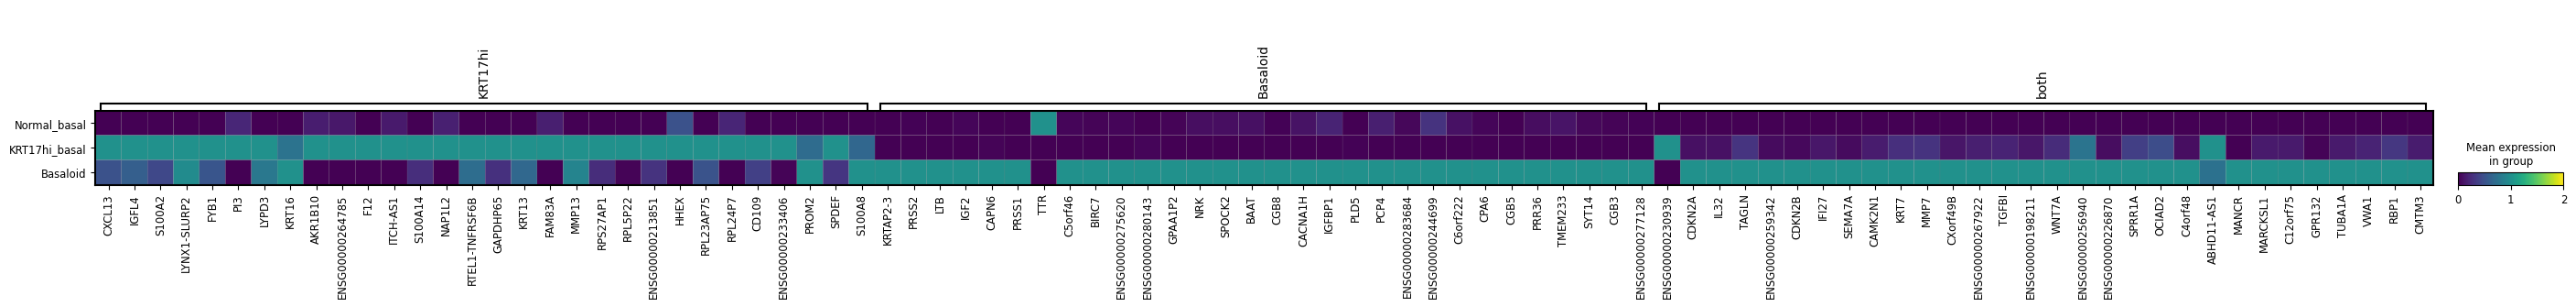

In [527]:
DE_markers = {
    'enr_basaloid':DE_Basaloid_vs_KRT17hi[(DE_Basaloid_vs_KRT17hi.adj_pval < 0.01) & (DE_Basaloid_vs_KRT17hi.lfc > 3)].sort_values("lfc", ascending=False)[0:40].index,
    'enr_KRT17hi':DE_Basaloid_vs_KRT17hi[(DE_Basaloid_vs_KRT17hi.adj_pval < 0.01) & (DE_Basaloid_vs_KRT17hi.lfc < -3)].sort_values("lfc", ascending=False)[0:40].index
}

DE_markers = {"KRT17hi":lfc_df[(lfc_df['signif_group'] == 'enr_KRT17hi') & (lfc_df['KRT17hi_vs_normal'] > 1)].sort_values('KRT17hi_vs_normal', ascending=False)[0:30].index,
"Basaloid":lfc_df[(lfc_df['signif_group'] == 'enr_Basaloid') & (lfc_df['Basaloid_vs_normal'] > 3)].sort_values('Basaloid_vs_normal', ascending=False)[0:30].index,
"both":lfc_df[(lfc_df['signif_group'] == 'enr_both') & (lfc_df['Basaloid_vs_normal'] > 2)].sort_values('Basaloid_vs_normal', ascending=False)[0:30].index}

sc.pl.matrixplot(acr_adata[acr_adata.obs['Celltype_HLCA'].isin(ct_groups['basal'])], DE_markers,standard_scale='var',
              groupby='nhood_groups', vmin=0, vmax=2)

In [577]:
DE_Basaloid_vs_KRT17hi['signif'] = np.nan
DE_Basaloid_vs_KRT17hi.loc[:,'signif'] = np.where((DE_Basaloid_vs_KRT17hi['lfc'] > 0) & (DE_Basaloid_vs_KRT17hi['adj_pval'] < 0.01), 'enr_Basaloid', DE_Basaloid_vs_KRT17hi['signif'])
DE_Basaloid_vs_KRT17hi.loc[:,'signif'] = np.where((DE_Basaloid_vs_KRT17hi['lfc'] < 0) & (DE_Basaloid_vs_KRT17hi['adj_pval'] < 0.01), 'enr_KRT17hi', DE_Basaloid_vs_KRT17hi['signif'])

enr_KRT17hi_vs_normal = DE_KRT17hi_vs_normal.gene_name[(DE_KRT17hi_vs_normal.adj_pval < 0.01) & (DE_KRT17hi_vs_normal.lfc > 0)]
enr_Basaloid_vs_normal = DE_Basaloid_vs_normal.gene_name[(DE_Basaloid_vs_normal.adj_pval < 0.01) & (DE_Basaloid_vs_normal.lfc > 0)]

DE_Basaloid_vs_KRT17hi['signif_vs_normal'] = np.nan
DE_Basaloid_vs_KRT17hi.loc[(DE_Basaloid_vs_KRT17hi['signif'] == 'enr_KRT17hi') & (DE_Basaloid_vs_KRT17hi.gene_name.isin(enr_KRT17hi_vs_normal)), 'signif_vs_normal'] = 'enr_KRT17hi'
DE_Basaloid_vs_KRT17hi.loc[(DE_Basaloid_vs_KRT17hi['signif'] == 'enr_Basaloid') & (DE_Basaloid_vs_KRT17hi.gene_name.isin(enr_Basaloid_vs_normal)), 'signif_vs_normal'] = 'enr_Basaloid'

/tmp/ipykernel_1924/2622689482.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  DE_Basaloid_vs_KRT17hi['signif'] = np.nan
/tmp/ipykernel_1924/2622689482.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  DE_Basaloid_vs_KRT17hi.loc[:,'signif'] = np.where((DE_Basaloid_vs_KRT17hi['lfc'] > 0) & (DE_Basaloid_vs_KRT17hi['adj_pval'] < 0.01), 'enr_Basaloid', DE_Basaloid_vs_KRT17hi['signif'])
/tmp/ipykernel_1924/2622689482.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Dat

In [578]:
DE_Basaloid_vs_KRT17hi[DE_Basaloid_vs_KRT17hi['signif_vs_normal'] == 'enr_KRT17hi'].sort_values('lfc')[0:50]

,pval,adj_pval,f_statistic,df1,df2,lfc,gene_name,signif,signif_vs_normal,drug_targets
SERPINB13,5.756759e-25,2.158785e-22,128.831611,1,291.127484,-9.039401,SERPINB13,enr_KRT17hi,enr_KRT17hi,False
CLCA2,6.401703e-24,1.846645e-21,121.992274,1,291.127484,-6.807423,CLCA2,enr_KRT17hi,enr_KRT17hi,False
SERPINB4,1.635200e-12,6.011765e-11,54.507138,1,291.127484,-5.979008,SERPINB4,enr_KRT17hi,enr_KRT17hi,False
LGALS7,4.978221e-26,2.333541e-23,135.900872,1,291.127484,-5.558895,LGALS7,enr_KRT17hi,enr_KRT17hi,False
CSTA,2.917727e-26,1.458863e-23,137.459897,1,291.127484,-5.472791,CSTA,enr_KRT17hi,enr_KRT17hi,False
ALDH3A1,1.371771e-17,1.469755e-15,82.982292,1,291.127484,-5.156967,ALDH3A1,enr_KRT17hi,enr_KRT17hi,False
LGALS7B,4.857456e-23,1.301104e-20,116.326838,1,291.127484,-5.090279,LGALS7B,enr_KRT17hi,enr_KRT17hi,False
GJB5,1.059486e-12,3.973073e-11,55.521410,1,291.127484,-4.954022,GJB5,enr_KRT17hi,enr_KRT17hi,False
VSNL1,1.173182e-28,1.099858e-25,153.900347,1,291.127484,-4.900418,VSNL1,enr_KRT17hi,enr_KRT17hi,False
IGFBP6,4.102320e-22,9.614813e-20,110.448349,1,291.127484,-4.859640,IGFBP6,enr_KRT17hi,enr_KRT17hi,False


In [579]:
DE_Basaloid_vs_KRT17hi[DE_Basaloid_vs_KRT17hi['signif_vs_normal'] == 'enr_Basaloid'].sort_values('lfc')[0:50]

,pval,adj_pval,f_statistic,df1,df2,lfc,gene_name,signif,signif_vs_normal,drug_targets
NUDC,2.624123e-03,9.786636e-03,9.210172,1,291.127484,0.522168,NUDC,enr_Basaloid,enr_Basaloid,False
CHMP2B,1.298245e-03,5.412362e-03,10.549389,1,291.127484,0.566025,CHMP2B,enr_Basaloid,enr_Basaloid,False
MPZL1,2.380298e-03,9.033359e-03,9.394621,1,291.127484,0.575755,MPZL1,enr_Basaloid,enr_Basaloid,False
NDUFB9,3.272206e-04,1.617768e-03,13.221303,1,291.127484,0.595113,NDUFB9,enr_Basaloid,enr_Basaloid,False
SPINT1,5.624176e-04,2.600575e-03,12.164064,1,291.127484,0.595623,SPINT1,enr_Basaloid,enr_Basaloid,False
RABAC1,2.273005e-03,8.760952e-03,9.481988,1,291.127484,0.616667,RABAC1,enr_Basaloid,enr_Basaloid,False
GSN,1.901347e-03,7.509271e-03,9.820965,1,291.127484,0.616783,GSN,enr_Basaloid,enr_Basaloid,False
WDR1,5.683130e-04,2.621370e-03,12.143797,1,291.127484,0.631291,WDR1,enr_Basaloid,enr_Basaloid,False
TMEM50A,3.389419e-05,2.202829e-04,17.734481,1,291.127484,0.638544,TMEM50A,enr_Basaloid,enr_Basaloid,False
SYNGR2,2.123703e-04,1.109176e-03,14.071315,1,291.127484,0.640796,SYNGR2,enr_Basaloid,enr_Basaloid,False


## Compare to drug targets

In [587]:
drug_targets_df = pd.read_table('/home/jovyan/mount/gdrive/diff2atlas/IPF_drug_targets.opentargets.csv', index_col=0)
drug_targets_df

,pathway,pathwayId,id,name,symbol,chembl_id,mechanism_of_action,action_type
0,"PI5P, PP2A and IER3 Regulate PI3K/AKT Signaling",R-HSA-6811558,ENSG00000113721,platelet derived growth factor receptor beta,PDGFRB,CHEMBL3039504,Platelet-derived growth factor receptor inhibitor,INHIBITOR
1,Constitutive Signaling by Aberrant PI3K in Cancer,R-HSA-2219530,ENSG00000113721,platelet derived growth factor receptor beta,PDGFRB,CHEMBL3039504,Platelet-derived growth factor receptor inhibitor,INHIBITOR
2,Signaling by PDGF,R-HSA-186797,ENSG00000113721,platelet derived growth factor receptor beta,PDGFRB,CHEMBL3039504,Platelet-derived growth factor receptor inhibitor,INHIBITOR
3,PIP3 activates AKT signaling,R-HSA-1257604,ENSG00000113721,platelet derived growth factor receptor beta,PDGFRB,CHEMBL3039504,Platelet-derived growth factor receptor inhibitor,INHIBITOR
4,RAF/MAP kinase cascade,R-HSA-5673001,ENSG00000113721,platelet derived growth factor receptor beta,PDGFRB,CHEMBL3039504,Platelet-derived growth factor receptor inhibitor,INHIBITOR
...,...,...,...,...,...,...,...,...
8,Regorafenib-resistant PDGFR mutants,R-HSA-9674403,ENSG00000134853,platelet derived growth factor receptor alpha,PDGFRA,CHEMBL502835,Platelet-derived growth factor receptor inhibitor,INHIBITOR
9,Sorafenib-resistant PDGFR mutants,R-HSA-9674404,ENSG00000134853,platelet derived growth factor receptor alpha,PDGFRA,CHEMBL502835,Platelet-derived growth factor receptor inhibitor,INHIBITOR
10,Signaling by PDGFRA extracellular domain mutants,R-HSA-9673770,ENSG00000134853,platelet derived growth factor receptor alpha,PDGFRA,CHEMBL502835,Platelet-derived growth factor receptor inhibitor,INHIBITOR
11,"Signaling by PDGFRA transmembrane, juxtamembra...",R-HSA-9673767,ENSG00000134853,platelet derived growth factor receptor alpha,PDGFRA,CHEMBL502835,Platelet-derived growth factor receptor inhibitor,INHIBITOR


In [581]:
DE_Basaloid_vs_KRT17hi['drug_targets'] = DE_Basaloid_vs_KRT17hi.gene_name.isin(drug_targets_df['symbol'].unique())

/tmp/ipykernel_1924/29397949.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  DE_Basaloid_vs_KRT17hi['drug_targets'] = DE_Basaloid_vs_KRT17hi.gene_name.isin(drug_targets_df['symbol'].unique())


In [582]:
DE_Basaloid_vs_KRT17hi[DE_Basaloid_vs_KRT17hi['drug_targets']]

,pval,adj_pval,f_statistic,df1,df2,lfc,gene_name,signif,signif_vs_normal,drug_targets
MMP7,3.438353e-05,2.230765e-04,17.705546,1,291.127484,2.109746,MMP7,enr_Basaloid,enr_Basaloid,True
ITGB6,5.373056e-13,2.202072e-11,57.114846,1,291.127484,1.576979,ITGB6,enr_Basaloid,enr_Basaloid,True
PIK3R3,2.499813e-01,4.013830e-01,1.328705,1,291.127484,-0.408222,PIK3R3,nan,NaN,True
ITGAV,2.510406e-08,3.420530e-07,32.828800,1,291.127484,1.344882,ITGAV,enr_Basaloid,enr_Basaloid,True
LPAR1,9.842631e-03,3.022921e-02,6.751691,1,291.127484,-0.884741,LPAR1,nan,NaN,True
TGFB2,1.437554e-06,1.329427e-05,24.224650,1,291.127484,1.492867,TGFB2,enr_Basaloid,enr_Basaloid,True
ADRB2,3.068260e-01,4.650409e-01,1.047965,1,291.127484,-0.342228,ADRB2,nan,NaN,True
EDNRA,1.194651e-05,8.767011e-05,19.852163,1,291.127484,-1.931566,EDNRA,enr_KRT17hi,NaN,True
PIK3R1,2.056528e-01,3.472301e-01,1.608950,1,291.127484,-0.435650,PIK3R1,nan,NaN,True
HBB,6.405393e-01,7.681556e-01,0.218494,1,291.127484,-1.348336,HBB,nan,NaN,True


In [593]:
DE_Basaloid_vs_KRT17hi[DE_Basaloid_vs_KRT17hi['signif_vs_normal'] == 'enr_KRT17hi'].sort_values("lfc", ascending=True)[0:50]

,pval,adj_pval,f_statistic,df1,df2,lfc,gene_name,signif,signif_vs_normal,drug_targets
SERPINB13,5.756759e-25,2.158785e-22,128.831611,1,291.127484,-9.039401,SERPINB13,enr_KRT17hi,enr_KRT17hi,False
CLCA2,6.401703e-24,1.846645e-21,121.992274,1,291.127484,-6.807423,CLCA2,enr_KRT17hi,enr_KRT17hi,False
SERPINB4,1.635200e-12,6.011765e-11,54.507138,1,291.127484,-5.979008,SERPINB4,enr_KRT17hi,enr_KRT17hi,False
LGALS7,4.978221e-26,2.333541e-23,135.900872,1,291.127484,-5.558895,LGALS7,enr_KRT17hi,enr_KRT17hi,False
CSTA,2.917727e-26,1.458863e-23,137.459897,1,291.127484,-5.472791,CSTA,enr_KRT17hi,enr_KRT17hi,False
ALDH3A1,1.371771e-17,1.469755e-15,82.982292,1,291.127484,-5.156967,ALDH3A1,enr_KRT17hi,enr_KRT17hi,False
LGALS7B,4.857456e-23,1.301104e-20,116.326838,1,291.127484,-5.090279,LGALS7B,enr_KRT17hi,enr_KRT17hi,False
GJB5,1.059486e-12,3.973073e-11,55.521410,1,291.127484,-4.954022,GJB5,enr_KRT17hi,enr_KRT17hi,False
VSNL1,1.173182e-28,1.099858e-25,153.900347,1,291.127484,-4.900418,VSNL1,enr_KRT17hi,enr_KRT17hi,False
IGFBP6,4.102320e-22,9.614813e-20,110.448349,1,291.127484,-4.859640,IGFBP6,enr_KRT17hi,enr_KRT17hi,False


In [597]:
DE_Basaloid_vs_KRT17hi[DE_Basaloid_vs_KRT17hi['signif_vs_normal'] == 'enr_Basaloid'].sort_values("lfc", ascending=False)[0:50]

,pval,adj_pval,f_statistic,df1,df2,lfc,gene_name,signif,signif_vs_normal,drug_targets
PRSS2,1.363593e-07,1.570960e-06,29.193896,1,291.127484,10.560398,PRSS2,enr_Basaloid,enr_Basaloid,False
IGF2,4.878280e-04,2.303974e-03,12.440944,1,291.127484,7.298383,IGF2,enr_Basaloid,enr_Basaloid,False
SCTR,1.079970e-20,1.928519e-18,101.606778,1,291.127484,7.136782,SCTR,enr_Basaloid,enr_Basaloid,False
CSF2,5.037940e-07,5.190186e-06,26.423509,1,291.127484,6.963023,CSF2,enr_Basaloid,enr_Basaloid,False
CAPN6,8.858404e-12,2.689799e-10,50.589570,1,291.127484,6.901301,CAPN6,enr_Basaloid,enr_Basaloid,False
CRCT1,3.524338e-05,2.282602e-04,17.655697,1,291.127484,6.864630,CRCT1,enr_Basaloid,enr_Basaloid,False
LTB,7.215788e-11,1.751405e-09,45.795455,1,291.127484,6.770648,LTB,enr_Basaloid,enr_Basaloid,False
CDH2,5.070061e-11,1.297797e-09,46.596733,1,291.127484,6.677664,CDH2,enr_Basaloid,enr_Basaloid,False
PRSS1,3.496507e-06,2.923501e-05,22.377922,1,291.127484,6.667611,PRSS1,enr_Basaloid,enr_Basaloid,False
CGB8,1.581495e-04,8.533247e-04,14.653919,1,291.127484,6.633108,CGB8,enr_Basaloid,enr_Basaloid,False


### Enrichment analysis

In [613]:
%matplotlib inline
%config InlineBackend.figure_format='retina' # mac
%load_ext autoreload
%autoreload 2
import gseapy as gp
from gseapy.plot import barplot, dotplot

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [668]:
names = gp.get_library_name()
gene_sets=['MSigDB_Hallmark_2020', 'GO_Biological_Process_2017']

gene_list = DE_Basaloid_vs_KRT17hi[DE_Basaloid_vs_KRT17hi['signif_vs_normal'] == 'enr_Basaloid'].sort_values("lfc", ascending=False).index.tolist()
background = DE_Basaloid_vs_KRT17hi.index.tolist()

# list, dataframe, series inputs are supported
enr = gp.enrichr(gene_list=gene_list,
                 gene_sets=gene_sets,
                 organism='Human', # don't forget to set organism to the one you desired! e.g. Yeast
                 background=background,
                 outdir='./enrichr/enr_Basaloid/',
                 # no_plot=True,
                 cutoff=0.5 # test dataset, use lower value from range(0,1)
                )

In [669]:
enr.results[enr.results['Adjusted P-value'] < 0.01]

,Gene_set,Term,Overlap,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Odds Ratio,Combined Score,Genes
0,MSigDB_Hallmark_2020,Epithelial Mesenchymal Transition,46/200,6.452484e-24,3.161717e-22,0,0,8.260323,441.081228,FBN2;NOTCH2;SPARC;NTM;TNFRSF11B;ENO2;AREG;FSTL...
1,MSigDB_Hallmark_2020,Apical Junction,26/200,2.456491e-08,6.018403e-07,0,0,4.011785,70.294288,SDC3;AMIGO2;NEXN;TNFRSF11B;ICAM1;GNAI2;ADAMTS5...
2,MSigDB_Hallmark_2020,KRAS Signaling Up,24/200,3.831691e-07,6.258429e-06,0,0,3.650453,53.934669,GUCY1A1;CSF2;FUCA1;IGF2;LIF;WNT7A;INHBA;TRAF1;...
3,MSigDB_Hallmark_2020,Coagulation,18/138,3.282232e-06,3.473706e-05,0,0,3.993672,50.428041,SPARC;MMP7;GSN;WDR1;PROS1;MMP2;PDGFB;FN1;FURIN...
4,MSigDB_Hallmark_2020,TGF-beta Signaling,11/54,3.555884e-06,3.473706e-05,0,0,6.772375,84.972357,ACVR1;BMP2;SMURF2;NOG;PMEPA1;FURIN;THBS1;SKIL;...
5,MSigDB_Hallmark_2020,Hypoxia,22/200,4.962437e-06,3.473706e-05,0,0,3.299049,40.293313,CDKN1A;TES;DTNA;CITED2;SDC3;PDGFB;ENO2;ETS1;EX...
6,MSigDB_Hallmark_2020,Myogenesis,22/200,4.962437e-06,3.473706e-05,0,0,3.299049,40.293313,MEF2C;CDKN1A;SPARC;DTNA;GSN;TNNC1;TNNC2;AK1;NA...
7,MSigDB_Hallmark_2020,TNF-alpha Signaling via NF-kB,21/200,1.659267e-05,9.033786e-05,0,0,3.126962,34.417066,CDKN1A;CSF2;LAMB3;RIPK2;LIF;INHBA;TRAF1;PTGS2;...
8,MSigDB_Hallmark_2020,p53 Pathway,21/200,1.659267e-05,9.033786e-05,0,0,3.126962,34.417066,CDKN1A;CDKN2B;RRAD;CDKN2A;FUCA1;AK1;LIF;PDGFA;...
9,MSigDB_Hallmark_2020,UV Response Dn,17/144,2.323855e-05,1.138689e-04,0,0,3.557655,37.959107,NOTCH2;FZD2;CITED2;ANXA4;LTBP1;KALRN;FBLN5;SMA...


In [670]:
gene_list = DE_Basaloid_vs_KRT17hi[DE_Basaloid_vs_KRT17hi['signif_vs_normal'] == 'enr_KRT17hi'].sort_values("lfc", ascending=False).index.tolist()
background = DE_Basaloid_vs_KRT17hi.index.tolist()

# list, dataframe, series inputs are supported
enr = gp.enrichr(gene_list=gene_list,
                 gene_sets=gene_sets,
                 organism='Human', # don't forget to set organism to the one you desired! e.g. Yeast
                 background=background,
                 outdir='./enrichr/enr_KRT17hi/',
                 # no_plot=True,
                 cutoff=0.5 # test dataset, use lower value from range(0,1)
                )

In [671]:
enr.results[enr.results['Adjusted P-value'] < 0.1]

,Gene_set,Term,Overlap,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Odds Ratio,Combined Score,Genes
0,MSigDB_Hallmark_2020,Oxidative Phosphorylation,21/200,5.489719e-14,2.415476e-12,0,0,10.299296,314.471643,NDUFA8;CYB5A;SLC25A3;ATP5PD;NDUFB6;MDH2;NDUFB5...
1,MSigDB_Hallmark_2020,Myc Targets V1,12/200,6.710804e-06,1.476377e-04,0,0,5.383712,64.129661,RANBP1;RSL1D1;FBL;SLC25A3;DUT;NOP16;SNRPD1;IMP...
2,MSigDB_Hallmark_2020,DNA Repair,7/150,2.481123e-03,3.572405e-02,0,0,4.050957,24.301873,DUT;MRPL40;MPC2;IMPDH2;POLR1D;NME1;APRT
3,MSigDB_Hallmark_2020,p53 Pathway,8/200,3.247641e-03,3.572405e-02,0,0,3.454096,19.791370,LDHB;GPX2;NOTCH1;PERP;ABCC5;CLCA2;HRAS;SERPINB5
4,MSigDB_Hallmark_2020,Pperoxisome,5/104,8.973054e-03,7.209268e-02,0,0,4.153882,19.579444,GSTK1;PRDX5;ABCC5;ECH1;HRAS
5,MSigDB_Hallmark_2020,Estrogen Response Early,7/200,1.159474e-02,7.209268e-02,0,0,2.993835,13.344131,SLC9A3R1;KRT19;KRT15;BAG1;BHLHE40;SLC2A1;AQP3
6,MSigDB_Hallmark_2020,Estrogen Response Late,7/200,1.159474e-02,7.209268e-02,0,0,2.993835,13.344131,SLC9A3R1;KRT19;TRIM29;PERP;NMU;BAG1;ASS1
7,MSigDB_Hallmark_2020,Fatty Acid Metabolism,6/158,1.310776e-02,7.209268e-02,0,0,3.251437,14.093521,ALDH3A1;CBR1;MDH2;ECH1;PRDX6;HSD17B10
44,GO_Biological_Process_2017,cornification (GO:0070268),13/108,7.108882e-10,3.831688e-07,0,0,11.646981,245.337902,CSTA;KRT5;KRT19;KRT16;PERP;KRT15;KRT14;PKP1;DS...
45,GO_Biological_Process_2017,keratinization (GO:0031424),11/153,2.894632e-06,7.801034e-04,0,0,6.521006,83.160122,KRT19;KRT16;KRT15;KRT14;PKP1;KRT5;DSG3;KRT6C;K...


## Genetics evidence

In [621]:
genetics = pd.read_csv('/nfs/team205/ed6/bin/patho-signatures/metadata/GWAS_stats/opentargets_genetics_FEV.csv', index_col=0)

In [627]:
FEV_genes = genetics['bestLocus2Genes_gene_symbol'].dropna().unique().tolist()

In [639]:
DE_Basaloid_vs_KRT17hi['GWAS_evidence'] = DE_Basaloid_vs_KRT17hi.gene_name.isin(FEV_genes)

/tmp/ipykernel_1924/93247168.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  DE_Basaloid_vs_KRT17hi['GWAS_evidence'] = DE_Basaloid_vs_KRT17hi.gene_name.isin(FEV_genes)


In [636]:
basaloid_genes = DE_Basaloid_vs_KRT17hi[DE_Basaloid_vs_KRT17hi['signif_vs_normal'] == 'enr_Basaloid'].sort_values("lfc", ascending=False).index
KRT17hi_genes = DE_Basaloid_vs_KRT17hi[DE_Basaloid_vs_KRT17hi['signif_vs_normal'] == 'enr_KRT17hi'].sort_values("lfc", ascending=False).index
basaloid_genes[basaloid_genes.isin(FEV_genes)]
KRT17hi_genes[KRT17hi_genes.isin(FEV_genes)]

Index(['EBPL'], dtype='object')

In [635]:
genetics[genetics.bestLocus2Genes_gene_symbol.isin(basaloid_genes[basaloid_genes.isin(FEV_genes)])]

,variant_id,variant_rsId,variant_chromosome,variant_position,variant_nearestCodingGeneDistance,pval,direction,bestLocus2Genes_gene_id,bestLocus2Genes_gene_symbol,bestLocus2Genes_score,studyId,traitReported,traitEfos,pmid,hasSumstats
7,5_149217130_TG_T,rs3839234,5.0,149217130.0,54729.0,4.000000e-11,NaN,ENSG00000173210,ABLIM3,0.634255,GCST004183,Lung function (FEV1),EFO_0004314,PMID:28166213,False
2,2_18111186_G_A,rs61067109,2.0,18111186.0,233339.0,3.000000e-11,+,ENSG00000170745,KCNS3,0.784526,GCST008480,Lung function (FEV1) [adults],EFO_0004314,PMID:26635082,False
25,1_218454682_T_A,rs6666381,1.0,218454682.0,109346.0,5.540000e-09,+,ENSG00000092969,TGFB2,0.833709,GCST007432,FEV1,EFO_0004314,PMID:30804560,True
26,1_218667969_A_G,rs28646156,1.0,218667969.0,322633.0,2.120000e-13,+,ENSG00000092969,TGFB2,0.595932,GCST007432,FEV1,EFO_0004314,PMID:30804560,True
31,2_5548233_C_A,rs10929647,2.0,5548233.0,144151.0,2.983000e-08,-,ENSG00000176887,SOX11,0.573468,GCST007432,FEV1,EFO_0004314,PMID:30804560,True
35,2_18111482_G_A,rs62126364,2.0,18111482.0,233635.0,3.764000e-27,+,ENSG00000170745,KCNS3,0.757340,GCST007432,FEV1,EFO_0004314,PMID:30804560,True
62,2_241556910_C_T,rs7572476,2.0,241556910.0,5486.0,6.250000e-13,-,ENSG00000176720,BOK,0.699769,GCST007432,FEV1,EFO_0004314,PMID:30804560,True
64,3_13746144_A_G,rs2974389,3.0,13746144.0,133927.0,1.703000e-12,-,ENSG00000154764,WNT7A,0.718152,GCST007432,FEV1,EFO_0004314,PMID:30804560,True
76,3_99073976_C_T,rs7631857,3.0,99073976.0,172281.0,1.149000e-28,-,ENSG00000057019,DCBLD2,0.611993,GCST007432,FEV1,EFO_0004314,PMID:30804560,True
127,5_142421651_A_G,rs253438,5.0,142421651.0,95196.0,1.332000e-09,+,ENSG00000187678,SPRY4,0.670946,GCST007432,FEV1,EFO_0004314,PMID:30804560,True


In [674]:
DE_Basaloid_vs_KRT17hi[(DE_Basaloid_vs_KRT17hi['GWAS_evidence']) & (~DE_Basaloid_vs_KRT17hi['signif_vs_normal'].isna())]

,pval,adj_pval,f_statistic,df1,df2,lfc,gene_name,signif,signif_vs_normal,drug_targets,GWAS_evidence
NTM,2.947390e-10,6.244471e-09,42.622080,1,291.127484,5.326702,NTM,enr_Basaloid,enr_Basaloid,False,True
GPC5,1.350139e-13,6.250645e-12,60.381111,1,291.127484,4.010290,GPC5,enr_Basaloid,enr_Basaloid,False,True
ITGB8,5.656030e-04,2.613692e-03,12.153087,1,291.127484,0.941399,ITGB8,enr_Basaloid,enr_Basaloid,False,True
CLIC6,1.927288e-06,1.726960e-05,23.613749,1,291.127484,1.626812,CLIC6,enr_Basaloid,enr_Basaloid,False,True
KCNS3,1.170318e-24,4.179709e-22,126.805161,1,291.127484,3.409667,KCNS3,enr_Basaloid,enr_Basaloid,False,True
BMP2,8.841786e-04,3.877976e-03,11.287919,1,291.127484,1.833714,BMP2,enr_Basaloid,enr_Basaloid,False,True
TGFB2,1.437554e-06,1.329427e-05,24.224650,1,291.127484,1.492867,TGFB2,enr_Basaloid,enr_Basaloid,True,True
DCBLD2,2.452749e-16,1.999524e-14,75.731734,1,291.127484,2.230729,DCBLD2,enr_Basaloid,enr_Basaloid,False,True
WNT7A,4.825110e-06,3.874553e-05,21.712757,1,291.127484,2.051676,WNT7A,enr_Basaloid,enr_Basaloid,False,True
ABLIM3,1.407749e-05,1.014229e-04,19.517216,1,291.127484,2.061120,ABLIM3,enr_Basaloid,enr_Basaloid,False,True


In [653]:
gene_set = {'GWAS_evidence': FEV_genes, 'Drug_targets':drug_targets_df.symbol.unique().tolist()}

In [654]:
names = gp.get_library_name()
gene_sets=['MSigDB_Hallmark_2020', 'GO_Biological_Process_2017']

gene_list = DE_Basaloid_vs_KRT17hi[DE_Basaloid_vs_KRT17hi['signif_vs_normal'] == 'enr_Basaloid'].sort_values("lfc", ascending=False).index.tolist()
background = DE_Basaloid_vs_KRT17hi.index.tolist()

# list, dataframe, series inputs are supported
enr = gp.enrichr(gene_list=gene_list,
                 gene_sets=gene_set,
                 organism='Human', # don't forget to set organism to the one you desired! e.g. Yeast
                 background=background,
                 outdir='./enrichr/enr_Basaloid/',
                 # no_plot=True,
                 cutoff=0.5 # test dataset, use lower value from range(0,1)
                )

In [655]:
enr.results

,Gene_set,Term,Overlap,P-value,Adjusted P-value,Odds Ratio,Genes
0,CUSTOM140528541651840,Drug_targets,4/16,0.069067,0.095515,2.722997,MMP7;ITGB6;ITGAV;TGFB2
1,CUSTOM140528541651840,GWAS_evidence,15/104,0.095515,0.095515,1.485409,BOK;GPC5;CLIC6;NTM;SOX11;KCNS3;NOG;WNT7A;SPRY4...


In [656]:
names = gp.get_library_name()
gene_sets=['MSigDB_Hallmark_2020', 'GO_Biological_Process_2017']

gene_list = DE_Basaloid_vs_KRT17hi[DE_Basaloid_vs_KRT17hi['signif_vs_normal'] == 'enr_KRT17hi'].sort_values("lfc", ascending=False).index.tolist()
background = DE_Basaloid_vs_KRT17hi.index.tolist()

# list, dataframe, series inputs are supported
enr = gp.enrichr(gene_list=gene_list,
                 gene_sets=gene_set,
                 organism='Human', # don't forget to set organism to the one you desired! e.g. Yeast
                 background=background,
                 outdir='./enrichr/enr_Basaloid/',
                 # no_plot=True,
                 cutoff=0.5 # test dataset, use lower value from range(0,1)
                )

2023-01-24 16:24:23,654 Warning: No enrich terms using library CUSTOM140528541651840 when cutoff = 0.5


In [657]:
enr.results

,Gene_set,Term,Overlap,P-value,Adjusted P-value,Odds Ratio,Genes
0,CUSTOM140528541651840,GWAS_evidence,1/104,0.971039,0.971039,0.426525,EBPL


In [661]:
DE_Basaloid_vs_KRT17hi[~DE_Basaloid_vs_KRT17hi['signif_vs_normal'].isna()]

,pval,adj_pval,f_statistic,df1,df2,lfc,gene_name,signif,signif_vs_normal,drug_targets,GWAS_evidence
SFTPC,1.896827e-05,1.328310e-04,18.910248,1,291.127484,4.684723,SFTPC,enr_Basaloid,enr_Basaloid,False,False
S100A2,9.583384e-16,6.780697e-14,72.357030,1,291.127484,-3.120493,S100A2,enr_KRT17hi,enr_KRT17hi,False,False
NTM,2.947390e-10,6.244471e-09,42.622080,1,291.127484,5.326702,NTM,enr_Basaloid,enr_Basaloid,False,True
NAPSA,1.854186e-17,1.958647e-15,82.217598,1,291.127484,4.613590,NAPSA,enr_Basaloid,enr_Basaloid,False,False
MMP7,3.438353e-05,2.230765e-04,17.705546,1,291.127484,2.109746,MMP7,enr_Basaloid,enr_Basaloid,True,False
...,...,...,...,...,...,...,...,...,...,...,...
COPG1,5.543727e-04,2.571302e-03,12.192073,1,291.127484,0.697836,COPG1,enr_Basaloid,enr_Basaloid,False,False
TMC7,8.952866e-06,6.741616e-05,20.442252,1,291.127484,1.110991,TMC7,enr_Basaloid,enr_Basaloid,False,False
BOK,1.955777e-06,1.746229e-05,23.583218,1,291.127484,1.571147,BOK,enr_Basaloid,enr_Basaloid,False,True
PNKD,1.400993e-03,5.760661e-03,10.403552,1,291.127484,-0.493777,PNKD,enr_KRT17hi,enr_KRT17hi,False,False


### Save output

In [662]:
DE_Basaloid_vs_KRT17hi.sort_values("lfc").to_csv(data_dir + '/DE_Basaloid_vs_KRT17hi.csv')
DE_Basaloid_vs_KRT17hi[~DE_Basaloid_vs_KRT17hi['signif_vs_normal'].isna()].sort_values("lfc").to_csv(data_dir + '/DE_Basaloid_vs_KRT17hi.signif.csv')

In [667]:
data_dir + '/DE_Basaloid_vs_KRT17hi.signif.csv'

'/lustre/scratch117/cellgen/team205/ed6/HLCA//DE_Basaloid_vs_KRT17hi.signif.csv'

In [ ]:
DE_Basaloid_vs_KRT17hi[~DE_Basaloid_vs_KRT17hi['signif_vs_normal'].isna()].sort_values("lfc").to_csv(data_dir + '/DE_Basaloid_vs_KRT17hi.signif.csv')

In [664]:
DE_Basaloid_vs_KRT17hi['GWAS_evidence']

,pval,adj_pval,f_statistic,df1,df2,lfc,gene_name,signif,signif_vs_normal,drug_targets,GWAS_evidence
SFTPC,0.000019,0.000133,18.910248,1,291.127484,4.684723,SFTPC,enr_Basaloid,enr_Basaloid,False,False
SCGB1A1,0.000003,0.000023,22.912508,1,291.127484,-3.064083,SCGB1A1,enr_KRT17hi,NaN,False,False
SCGB3A2,0.013034,0.038336,6.240978,1,291.127484,2.110843,SCGB3A2,nan,NaN,False,False
SFTPA2,0.313130,0.472626,1.020960,1,291.127484,0.963716,SFTPA2,nan,NaN,False,False
SFTPA1,0.272312,0.426020,1.209639,1,291.127484,1.577379,SFTPA1,nan,NaN,False,False
...,...,...,...,...,...,...,...,...,...,...,...
GGT6,0.000058,0.000360,16.639967,1,291.127484,-1.543639,GGT6,enr_KRT17hi,NaN,False,False
S1PR3,0.567629,0.710105,0.327411,1,291.127484,0.678842,S1PR3,nan,NaN,False,False
MOGAT2,0.993748,0.998541,0.000062,1,291.127484,0.014797,MOGAT2,nan,NaN,False,False
SLC4A11,0.645119,0.772043,0.212551,1,291.127484,-0.236795,SLC4A11,nan,NaN,False,False
